1. Database Setup and Table Creation

In [1]:
import sqlite3

# Connect to the database (it will be created if it doesn't exist)
connection = sqlite3.connect('waste_management.db')
cursor = connection.cursor()

# Create Users table
cursor.execute('''
CREATE TABLE IF NOT EXISTS Users (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    name TEXT NOT NULL,
    location TEXT NOT NULL
)
''')

# Create DropoffPoints table
cursor.execute('''
CREATE TABLE IF NOT EXISTS DropoffPoints (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    name TEXT NOT NULL,
    latitude REAL NOT NULL,
    longitude REAL NOT NULL
)
''')

# Create RecyclingActivities table
cursor.execute('''
CREATE TABLE IF NOT EXISTS RecyclingActivities (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    user_id INTEGER NOT NULL,
    waste_type TEXT NOT NULL,
    weight REAL NOT NULL,
    date TEXT NOT NULL,
    FOREIGN KEY(user_id) REFERENCES Users(id)
)
''')

# Commit and close
connection.commit()
connection.close()
print("Database and tables created successfully!")


Database and tables created successfully!


2. Insert Sample Data into the Database

In [2]:
# Reconnect to the database
connection = sqlite3.connect('waste_management.db')
cursor = connection.cursor()

# Insert sample data into Users table
users = [
    ('Alice Johnson', 'Lagos'),
    ('Bob Smith', 'Abuja'),
    ('Charlie Brown', 'Kano')
]
cursor.executemany('INSERT INTO Users (name, location) VALUES (?, ?)', users)

# Insert sample data into DropoffPoints table
dropoff_points = [
    ('Recycling Center A', 6.5244, 3.3792),  # Lagos
    ('Recycling Center B', 9.0765, 7.3986),  # Abuja
    ('Recycling Center C', 12.0022, 8.5919)  # Kano
]
cursor.executemany('INSERT INTO DropoffPoints (name, latitude, longitude) VALUES (?, ?, ?)', dropoff_points)

# Insert sample data into RecyclingActivities table
recycling_activities = [
    (1, 'Plastic', 5.2, '2024-11-18'),
    (1, 'Paper', 3.0, '2024-11-17'),
    (2, 'Glass', 7.1, '2024-11-16'),
    (3, 'Metal', 4.5, '2024-11-15'),
    (2, 'Plastic', 2.5, '2024-11-14')
]
cursor.executemany('INSERT INTO RecyclingActivities (user_id, waste_type, weight, date) VALUES (?, ?, ?, ?)', recycling_activities)

# Commit and close
connection.commit()
connection.close()
print("Sample data inserted successfully!")


Sample data inserted successfully!


3. Fetch Data from Database and Display

In [3]:
# Reconnect to the database and fetch Users data
connection = sqlite3.connect('waste_management.db')
cursor = connection.cursor()

cursor.execute('SELECT * FROM Users')
for row in cursor.fetchall():
    print(row)

connection.close()

# Reconnect and fetch RecyclingActivities data
connection = sqlite3.connect('waste_management.db')
cursor = connection.cursor()

cursor.execute('SELECT * FROM RecyclingActivities')
for row in cursor.fetchall():
    print(row)

connection.close()


(1, 'Alice Johnson', 'Lagos')
(2, 'Bob Smith', 'Abuja')
(3, 'Charlie Brown', 'Kano')
(1, 1, 'Plastic', 5.2, '2024-11-18')
(2, 1, 'Paper', 3.0, '2024-11-17')
(3, 2, 'Glass', 7.1, '2024-11-16')
(4, 3, 'Metal', 4.5, '2024-11-15')
(5, 2, 'Plastic', 2.5, '2024-11-14')


4. Visualize Total Weight of Waste Recycled by Users

C:\Users\charl\AppData\Local\Temp\ipykernel_11340\361301525.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TotalWeight', y='UserName', data=df, palette='viridis')


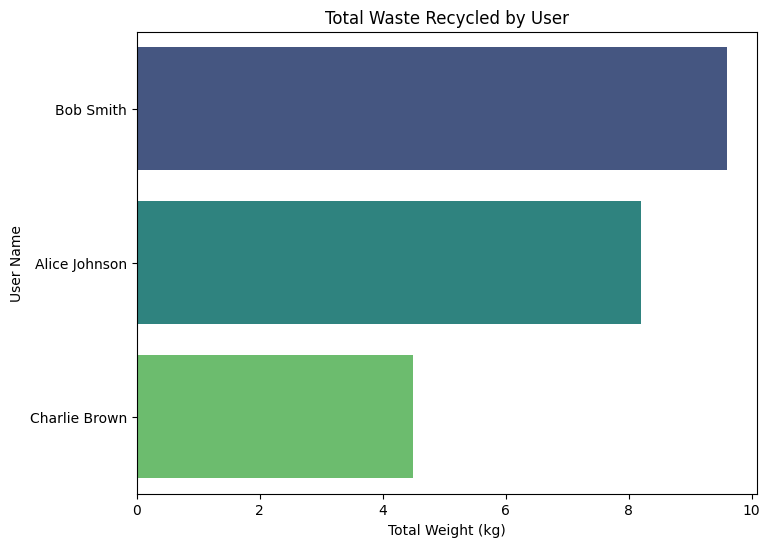

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reconnect to the database
connection = sqlite3.connect('waste_management.db')

# Query data to sum total weight of recycled waste by user
query = '''
SELECT Users.name AS UserName, SUM(RecyclingActivities.weight) AS TotalWeight
FROM Users
JOIN RecyclingActivities ON Users.id = RecyclingActivities.user_id
GROUP BY Users.id
ORDER BY TotalWeight DESC
'''
df = pd.read_sql_query(query, connection)

# Plot bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='TotalWeight', y='UserName', data=df, palette='viridis')
plt.title('Total Waste Recycled by User')
plt.xlabel('Total Weight (kg)')
plt.ylabel('User Name')
plt.show()

connection.close()


5. Display Map of Waste Drop-off Points

In [5]:
import folium

# Create map centered on Nigeria
m = folium.Map(location=[9.0820, 8.6753], zoom_start=6)

# Add dropoff points to the map
connection = sqlite3.connect('waste_management.db')
cursor = connection.cursor()
cursor.execute('SELECT name, latitude, longitude FROM DropoffPoints')

for name, lat, lon in cursor.fetchall():
    folium.Marker([lat, lon], popup=name).add_to(m)

# Save the map to an HTML file
m.save('waste_dropoff_map_with_recycling.html')
print("Map saved to 'waste_dropoff_map_with_recycling.html'!")

connection.close()


Map saved to 'waste_dropoff_map_with_recycling.html'!


6. Add Interactive Widgets for User Selection

In [6]:
import ipywidgets as widgets
from IPython.display import display

# Reconnect to the database and create dropdown for users
connection = sqlite3.connect('waste_management.db')
users_df = pd.read_sql_query('SELECT id, name FROM Users', connection)

dropdown = widgets.Dropdown(
    options=users_df['name'],
    description='Select User:',
)

# Function to display user recycling data based on dropdown selection
def show_user_data(selected_user):
    user_id = users_df[users_df['name'] == selected_user]['id'].values[0]
    query = f'''
    SELECT waste_type, weight, date
    FROM RecyclingActivities
    WHERE user_id = {user_id}
    '''
    user_data = pd.read_sql_query(query, connection)
    display(user_data)

# Interactive widget to call the function when user is selected
widgets.interactive(show_user_data, selected_user=dropdown)

connection.close()


In [2]:

import sqlite3
import folium
from ipywidgets import widgets, interactive

# Function to display all the data interactively
def show_user_data_with_rewards(selected_user):
    connection = sqlite3.connect('waste_management.db')
    cursor = connection.cursor()
    
    # Fetch user data
    query = '''
    SELECT Users.name, Users.location, SUM(RecyclingActivities.weight) AS TotalWeight
    FROM Users
    LEFT JOIN RecyclingActivities ON Users.id = RecyclingActivities.user_id
    WHERE Users.name = ?
    GROUP BY Users.id
    '''
    cursor.execute(query, (selected_user,))
    user_data = cursor.fetchone()
    
    if user_data:
        name, location, total_weight = user_data
        print(f"User: {name}\nLocation: {location}\nTotal Waste Recycled: {total_weight} kg")
    else:
        print(f"No data available for {selected_user}.")
    
    connection.close()

def run_app(selected_user):
    # Show user data
    show_user_data_with_rewards(selected_user)
    
    # Reconnect to database
    connection = sqlite3.connect('waste_management.db')
    cursor = connection.cursor()
    
    # Update folium map with the new data
    m = folium.Map(location=[9.0820, 8.6753], zoom_start=6)
    
    cursor.execute('SELECT name, latitude, longitude FROM DropoffPoints')
    for name, lat, lon in cursor.fetchall():
        folium.Marker([lat, lon], popup=name).add_to(m)
    
    # Save updated map
    m.save('updated_waste_dropoff_map_with_recycling.html')
    print("Map updated with recycling activities and saved!")

    connection.close()

# Create dropdown for user selection
connection = sqlite3.connect('waste_management.db')
cursor = connection.cursor()
cursor.execute('SELECT name FROM Users')
users = [row[0] for row in cursor.fetchall()]
connection.close()

dropdown = widgets.Dropdown(
    options=users,
    description='Select User:',
    disabled=False
)

# Interactive widget to call the function
interactive_widget = interactive(run_app, selected_user=dropdown)
display(dropdown, interactive_widget)


Dropdown(description='Select User:', options=('Alice Johnson', 'Bob Smith', 'Charlie Brown'), value='Alice Joh…

interactive(children=(Dropdown(description='Select User:', options=('Alice Johnson', 'Bob Smith', 'Charlie Bro…

# Waste Management App

This is a Python-based waste management application built using Jupyter Notebook.

## Features
- Mapping of waste drop-off points using **folium**.
- Tracking recycling activities by users and calculating the total waste recycled.
- Interactive widgets for selecting a user and displaying their recycling activities.
- Rewards system based on waste recycling.

## How to Run
1. Clone the repository or download the notebook.
2. Install dependencies by running:
    ```bash
    pip install -r requirements.txt
    ```
3. Open the Jupyter notebook and run the code cells.
4. The map and interactive widgets should be displayed.

## Files
- `waste_management_project.ipynb`: The main Jupyter notebook.
- `waste_dropoff_map_with_recycling.html`: Interactive map of drop-off points.
- `requirements.txt`: List of dependencies.

